# Working with Sentinel-2

This notebook demonstrates how to find, load and process Sentinel-2 CARD images on the DIAS.

The DIAS stores the CARD images in the S3 store. In order to work with the data in a program (or for downloading), you first need to transfer it to local disk. For this, you need to know the S3 "end-point" where the data is stored. For this, we use the DIAS data base.


In [4]:
# import required libraries for this Notebook
import os
import sys
import glob
import rasterio
import psycopg2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lxml import etree
from rasterio import plot
from datetime import datetime, time
from ipywidgets import widgets


In [5]:
# Select a date for the S2 image 
obs_date = widgets.DatePicker(description='Obs a Date',disabled=False,
                              value=datetime.date(datetime(2018, 8, 14)))
obs_date

DatePicker(value=datetime.date(2018, 8, 14), description='Obs a Date')

In [6]:
# Set the database credentials

DB_HOST = '172.17.0.2'
DB_NAME = 'postgres'
DB_USER = 'postgres'
DB_PORT = '5432'
DB_PASS = ''
DB_SCHE = 'public'

conn_str = f"host={DB_HOST} dbname={DB_NAME} user={DB_USER} port={DB_PORT} password={DB_PASS}"

In [7]:
# Connect to the database
conn = psycopg2.connect(conn_str)

In [8]:
# Select a parcels id.
parcels_table = 'fr.parcels_2020'
parcel_id = 410200

In [13]:
# Get the S2 frames that cover a parcel identified by parcel
# ID from the dias_catalogue for the selected date.

getS2framesSql = f"""
    SELECT reference, obstime, status
    FROM dias_catalogue, {parcels_table}
    WHERE card = 's2'
    And footprint && st_transform(wkb_geometry, 4326)
    And ogc_fid = {parcel_id}
    ORDER by obstime asc;
"""

# Read result set into a pandas dataframe
df_s2frames = pd.read_sql_query(getS2framesSql, conn)
# df_s2frames['obsdate'] = df_s2frames['obstime'].dt.date
# df_s2frame = df_s2frames[(df_s2frames['obsdate'] == obs_date.value)]

df_s2frames

,reference,obstime,status


The _reference_ attribute provides the S3 address for each S2 CARD image. However, this is only the top entry point (like the top directory in a directory tree). To access individual (image) files, we need to first discover the relevant file locations. 

To access S3 stored objects, we need the __boto3__ python library and __S3 access credentials__. We use the __object_storage.py__ script to search for and copy files from S3 to local disk. 



In [12]:
# Get the first reference from the dataframe. (reference.value)
reference = df_s2frame['reference'].tolist()[0]

s3path, file_info = object_storage.get_file_location(reference)
fpath = f"{data_}{file_info['sat']}_{file_info['full_tstamp']}/"

print("The path of the files in the object storage is: \n" + s3path)
print("\nThe local path of the files is: \n" + fpath)

The path of the files in the object storage is: 
Sentinel-2/MSI/L2A/2018/08/04/S2B_MSIL2A_20180804T105019_N0208_R051_T31TCG_20180804T173100.SAFE/GRANULE/

The local path of the files is: 
/home/eouser/jrc-dias/data/S2B_20180804T105019/


In [13]:
# Get list of files from the bucket.
bucket_files = object_storage.list_files(bucket, s3path)
key_list = [file['Key'] for file in bucket_files]
band_list = [s for s in key_list if "/IMG_DATA/" in s]

# Get the bands for the selected reference.
B03_10m = next((x for x in band_list if "_B03_10m" in x), None)
B04_10m = next((x for x in band_list if "_B04_10m" in x), None)
B08_10m = next((x for x in band_list if "_B08_10m" in x), None)
SCL_20m = next((x for x in band_list if "_SCL_20m" in x), None)

# We want 3 bands in the 10 m resolution and the SCL band at 20 m resolution
selection = [B03_10m, B04_10m, B08_10m, SCL_20m]
selection

['Sentinel-2/MSI/L2A/2018/08/04/S2B_MSIL2A_20180804T105019_N0208_R051_T31TCG_20180804T173100.SAFE/GRANULE/L2A_T31TCG_A007370_20180804T105811/IMG_DATA/R10m/T31TCG_20180804T105019_B03_10m.jp2',
 'Sentinel-2/MSI/L2A/2018/08/04/S2B_MSIL2A_20180804T105019_N0208_R051_T31TCG_20180804T173100.SAFE/GRANULE/L2A_T31TCG_A007370_20180804T105811/IMG_DATA/R10m/T31TCG_20180804T105019_B04_10m.jp2',
 'Sentinel-2/MSI/L2A/2018/08/04/S2B_MSIL2A_20180804T105019_N0208_R051_T31TCG_20180804T173100.SAFE/GRANULE/L2A_T31TCG_A007370_20180804T105811/IMG_DATA/R10m/T31TCG_20180804T105019_B08_10m.jp2',
 'Sentinel-2/MSI/L2A/2018/08/04/S2B_MSIL2A_20180804T105019_N0208_R051_T31TCG_20180804T173100.SAFE/GRANULE/L2A_T31TCG_A007370_20180804T105811/IMG_DATA/R20m/T31TCG_20180804T105019_SCL_20m.jp2']

In [14]:
# Copy input data from S3 to local disk
os.makedirs(fpath, exist_ok=True)

for s in selection:
    try:
        local_file = fpath + s[-11:]
        object_storage.get_file(s, local_file, bucket)
        print(f"Image {s[-11:]} found in bucket {bucket}")
    except Exeption as err:
        print(f"Image {s[-11:]} NOT found in bucket {bucket}")

-Downloading to local file-


File downloaded as:  /home/eouser/jrc-dias/data/S2B_20180804T105019/B03_10m.jp2

Image B03_10m.jp2 found in bucket DIAS
-Downloading to local file-


File downloaded as:  /home/eouser/jrc-dias/data/S2B_20180804T105019/B04_10m.jp2

Image B04_10m.jp2 found in bucket DIAS
-Downloading to local file-


File downloaded as:  /home/eouser/jrc-dias/data/S2B_20180804T105019/B08_10m.jp2

Image B08_10m.jp2 found in bucket DIAS
-Downloading to local file-


File downloaded as:  /home/eouser/jrc-dias/data/S2B_20180804T105019/SCL_20m.jp2

Image SCL_20m.jp2 found in bucket DIAS


In the _IMG_DATA_ 'folder' of the _s3path_, we expect to find the image bands. We select the 10 m bands to create some visualizations and show some simple image processing steps.  

In [15]:
%matplotlib inline

file_set = sorted(glob.glob(f"{fpath}*_10m.jp2"))
print(file_set)

['/home/eouser/jrc-dias/data/S2B_20180804T105019/B03_10m.jp2', '/home/eouser/jrc-dias/data/S2B_20180804T105019/B04_10m.jp2', '/home/eouser/jrc-dias/data/S2B_20180804T105019/B08_10m.jp2']


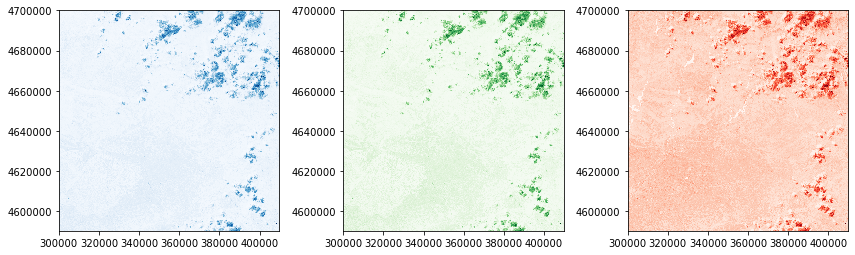

In [16]:
#import bands as separate 1 band raster
band3 = rasterio.open(file_set[0], driver='JP2OpenJPEG') #green
band4 = rasterio.open(file_set[1], driver='JP2OpenJPEG') #red
band8 = rasterio.open(file_set[2], driver='JP2OpenJPEG') #nir

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
plot.show(band3, ax=ax1, cmap='Blues')
plot.show(band4, ax=ax2, cmap='Greens')
plot.show(band8, ax=ax3, cmap='Reds')
fig.tight_layout()

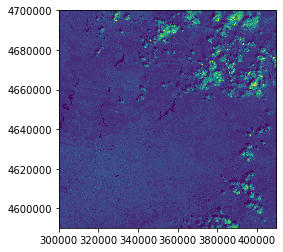

In [17]:
#export true color image
falseColor = None 

falseColor = rasterio.open(fpath + 'SentinelFalseColor.png','w',driver='PNG',
                         width=band8.width, height=band8.height,
                         count=3,
                         crs=band8.crs,
                         transform=band8.transform,
                         dtype=band8.dtypes[0]
                         )
falseColor.write(band8.read(1),1) #nir
falseColor.write(band4.read(1),2) #red
falseColor.write(band3.read(1),3) #green
falseColor.close()

src = rasterio.open(fpath + 'SentinelFalseColor.png', count=3)
plot.show(src)

(3, 200, 200)
0 75.0 3372.0


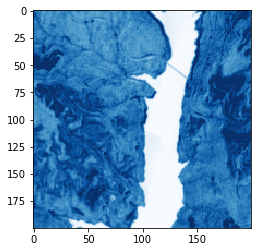

1 211.95 1954.0


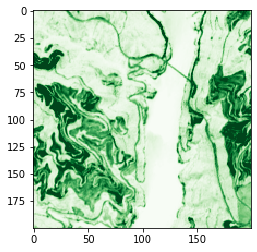

2 491.0 1396.0


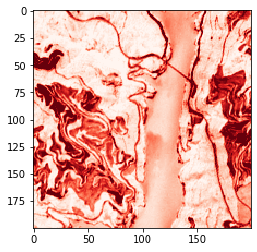

In [18]:
# from rasterio import Window
#src = rasterio.open(r"SentinelFalseColor.png", window = (0, 0, 800, 800), count=3)
with rasterio.open(fpath + 'SentinelFalseColor.png', count=3) as src:
     w = src.read([1,2,3], window=((5000, 5200), (5000, 5200)))

print(w.shape)

cmaps = ['Blues', 'Greens', 'Reds', 'gray']

for b in [0,1,2]:
    w_5 = np.percentile(w[b], 5.0)
    w_95 = np.percentile(w[b], 95.0)
    print(b, round(w_5,3), round(w_95,3))

    image = np.clip(255 * (w[b] - w_5) /(w_95 - w_5), 0, 255).astype(np.uint8)

    plot.show(image, cmap=cmaps[b])

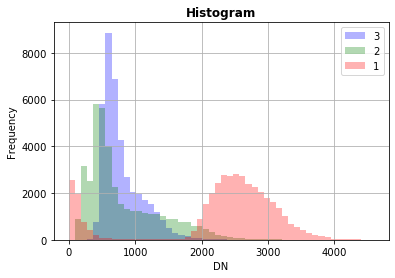

In [19]:
plot.show_hist(w, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram")


In [20]:
# Close database connection
conn.close()

The connection to the database is now closed.
